In [1]:
########### IMPORT MODULES ########### 

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Documents/Google Drive File Stream/O meu disco/Ines - IBL/Analysis/CA')

Connecting ines.laranjeira@datajoint.internationalbrainlab.org:3306


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

In [3]:
########### WEIGHINGS ########### 
# date range: from after CA concentration switch

weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"' 
# baseline weight corresponds to the last weighing before mice were put on each of the water regimes
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date = "2018-09-24"' 

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date

weight_df = pd.DataFrame(b.fetch(as_dict=True))
weight_df.tail(n=10)

baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
baseline_df.tail(n=10)

,avg_weight,ear_mark,lab_name,protocol_number,session_date,sex,subject_birth_date,subject_description,subject_line,subject_nickname,subject_project,subject_source,subject_ts,subject_uuid,subjectlab_ts,subjectproject_ts
7,15.960000,None,mainenlab,1,2018-09-24,F,2018-08-08,None,None,ZM_342,collab_citricacid,None,2019-08-06 21:30:42,342f4745-7606-4506-b81d-c7e27ed78c44,2019-08-06 21:41:41,2019-09-16 12:26:55
8,24.750000,None,mainenlab,1,2018-09-24,M,2018-07-23,None,None,ZM_208,collab_citricacid,None,2019-08-06 21:30:42,3cc9e62f-5a3d-43ab-9ed6-66dcc6d3a3be,2019-08-06 21:41:41,2019-09-16 12:26:56
9,25.190001,None,mainenlab,1,2018-09-24,M,2018-07-23,None,None,ZM_209,collab_citricacid,None,2019-08-06 21:30:42,43b91da7-0be5-493a-bec5-ebd8d624a573,2019-08-06 21:41:41,2019-09-16 12:26:56
10,26.459999,None,mainenlab,1,2018-09-24,M,2018-07-22,None,None,ZM_200,collab_citricacid,None,2019-08-06 21:30:42,704479d9-9375-4aaa-9e20-c304e0e8cb09,2019-08-06 21:41:41,2019-09-16 12:26:57
11,20.650000,None,mainenlab,3,2018-09-24,M,2018-08-08,None,Thy1-GCaMP6s,ZM_335,collab_citricacid,None,2019-08-06 21:30:42,76f99b7a-94e6-41d4-8e2d-6bdd7b1478c3,2019-08-06 21:41:41,2019-09-16 12:26:57
12,26.410000,None,mainenlab,1,2018-09-24,M,2018-07-23,None,None,ZM_205,collab_citricacid,None,2019-08-06 21:30:42,99758296-c09d-48e5-bbfd-dd372322c724,2019-08-06 21:41:41,2019-09-16 12:26:57
13,22.400000,None,mainenlab,1,2018-09-24,M,2018-08-08,None,None,ZM_337,collab_citricacid,None,2019-08-06 21:30:42,ae348d98-4f39-49e5-8c54-82588552d938,2019-08-06 21:41:41,2019-09-16 12:26:58
14,20.150000,None,mainenlab,1,2018-09-24,F,2018-07-22,None,None,ZM_203,collab_citricacid,None,2019-08-06 21:30:42,b00ab20e-27fd-4cf5-93a6-f7b852370c86,2019-08-06 21:41:41,2019-09-16 12:26:58
15,20.250000,None,mainenlab,1,2018-09-24,F,2018-07-23,None,None,ZM_210,collab_citricacid,None,2019-08-06 21:30:42,c600bc40-2f6f-449f-99be-562f6fbe331e,2019-08-06 21:41:41,2019-09-16 12:26:58
16,20.320000,None,mainenlab,1,2018-09-24,M,2018-08-08,None,None,ZM_338,collab_citricacid,None,2019-08-06 21:30:42,f8f2ec95-bc15-4c72-bf93-74185cbd049f,2019-08-06 21:41:41,2019-09-16 12:26:59


In [4]:
########### WEIGHINGS NORMALIZATION ########### 

normalized_df = weight_df.copy() # create new data frame which will have the normalized weights

subject_count = 0
for s in baseline_df['subject_uuid']:
    subject_count += 1
    entry = normalized_df['subject_uuid'] == s # outputs list of booleans - True for all entries of mouse s    
    
    weight_count = 0
    for d in entry:
        weight_count += 1
        if d == True:
            normalized_df['avg_weight'][weight_count-1] = normalized_df['avg_weight'][weight_count-1] / baseline_df['avg_weight'][subject_count-1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CA = '2% Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

normalized_df['condition'] = normalized_df.subject_nickname.map(condition_map)

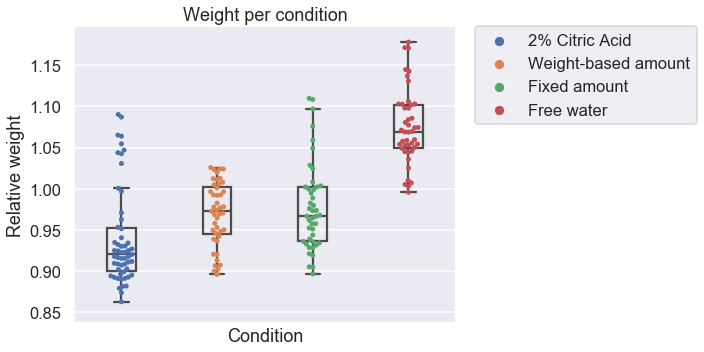

In [9]:
########### PLOTS ########### 

f = plt.figure(figsize=(10, 5))
sns.swarmplot(x="condition", y="avg_weight", order=['2% Citric Acid', 
        'Weight-based amount', 'Fixed amount', 'Free water'], hue="condition", 
        data=normalized_df)
sns.boxplot(x="condition", y="avg_weight", order=['2% Citric Acid', 
        'Weight-based amount', 'Fixed amount', 'Free water'], 
        data=normalized_df, fliersize=0, boxprops={'facecolor':'None'}, width=.3)
plt.ylabel("Relative weight")     
plt.xlabel("Condition")    
plt.xticks([])
plt.title("Weight per condition")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.tight_layout()
f.savefig(os.path.join(figpath, "weight_over_time.pdf"))